In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

In [3]:
def get_data2():
    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter('training', 'testing'),
                 get_y = parent_label)
    dls = mnist.dataloaders(untar_data(URLs.MNIST))
    x_train, y_train = zip(*dls.train_ds)
    x_valid, y_valid = zip(*dls.valid_ds)
    
    x_train = tensor(list(map(array, x_train)), dtype=torch.float32).view(len(dls.train_ds), -1)
    x_valid = tensor(list(map(array, x_valid)), dtype=torch.float32).view(len(dls.valid_ds), -1)
    y_train = tensor(y_train)
    y_valid = tensor(y_valid)
    
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train, x_valid = normalize(x_train, x_mean, x_std), normalize(x_valid, x_mean, x_std)
    x_train, x_valid = x_train / 255.0, x_valid / 255.0
    
    return x_train, y_train, x_valid, y_valid

In [4]:
x_train, y_train, x_valid, y_valid = get_data2()

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
x_train.shape

torch.Size([60000, 784])

In [7]:
n,m = x_train.shape
c = int(y_train.max() + 1)
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [9]:
model = Model(m,nh,c)

In [10]:
pred = model(x_train)

In [11]:
pred.shape

torch.Size([60000, 10])

In [12]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
def log_softmax(pred): pred - pred.exp().sum(dim=-1, keepdim=True).log()

In [14]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

In [15]:
def log_softmax(pred): return pred - pred.logsumexp(-1, keepdim=True)

In [16]:
log_softmax(pred).shape

torch.Size([60000, 10])

In [17]:
def nll(pred, target): return -pred[range(target.shape[0]), target].mean()

In [18]:
y_train.shape[0]

60000

In [19]:
loss = nll(pred, y_train)
loss

tensor(-0.0271, grad_fn=<NegBackward>)

In [20]:
nll(log_softmax(pred), y_train)

tensor(2.3075, grad_fn=<NegBackward>)

In [21]:
F.nll_loss(F.log_softmax(pred, -1), y_train)

tensor(2.3068, grad_fn=<NllLossBackward>)

In [23]:
loss_func = F.cross_entropy

In [24]:
def accuracy(pred, target): return (pred.argmax(-1) == target).float().mean()

In [25]:
accuracy(pred, y_train) # ~ 10%

tensor(0.0974)

In [26]:
bs  = 64

xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.0189, -0.0434, -0.0815, -0.0618,  0.1434,  0.0554,  0.1043,  0.0885,
          0.1249, -0.0639], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [27]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(2.1914, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(1.)

In [29]:
lr = 0.5
epochs = 1

In [31]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        preds = model(xb)
        loss = loss_func(preds, yb)
        
        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [32]:
loss_func(preds, yb), accuracy(preds, yb)

(tensor(0.0015, grad_fn=<NllLossBackward>), tensor(1.))

## Optimizer

In [33]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [34]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,c))

In [35]:
opt = Optimizer(model.parameters())

In [36]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [39]:
loss_func(model(xb), yb)

tensor(0.0014, grad_fn=<NllLossBackward>)

In [40]:
accuracy(model(xb), yb)

tensor(1.)

In [42]:
xb.shape, yb.shape

(torch.Size([32, 784]), torch.Size([32]))

## Dataset

In [43]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i], self.y[i]

In [44]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

In [48]:
len(train_ds), len(valid_ds)

(60000, 10000)

## DataLoader

In [52]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self): 
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [53]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [140]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [56]:
from torch.optim import SGD

In [284]:
def get_model():
    "returns model and optimizer"
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,c))
    return model, SGD(model.parameters(), lr=0.5)

In [226]:
model, opt = get_model()

In [227]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(2.2982, grad_fn=<NllLossBackward>), tensor(0.0938))

In [228]:
fit()

TypeError: fit() missing 5 required positional arguments: 'model', 'train_dl', 'valid_dl', 'loss_func', and 'opt'

In [66]:
def loss_and_accuracy(model, xb, yb):
    return loss_func(model(xb), yb), accuracy(model(xb), yb)

In [67]:
loss_and_accuracy(model, xb, yb)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

## RandomSampling

In [155]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [156]:
small_ds = Dataset(*train_ds[:10])

In [157]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [158]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([2, 8, 7]), tensor([6, 0, 1]), tensor([4, 9, 5]), tensor([3])]

In [159]:
def collate(b):
    xb, yb = zip(*b)
    return torch.stack(xb), torch.stack(yb)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [160]:
train_samp = Sampler(train_ds, bs, True)
valid_samp = Sampler(valid_ds, bs, False)

In [161]:
train_dl = DataLoader(train_ds, train_samp, collate)
valid_dl = DataLoader(valid_ds, valid_samp, collate)

tensor(4)

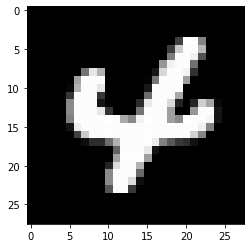

In [162]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

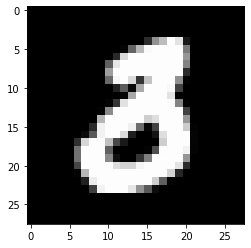

In [163]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [164]:
model, opt = get_model()
loss_and_accuracy(model, xb, yb)

(tensor(2.3001, grad_fn=<NllLossBackward>), tensor(0.0625))

In [165]:
fit()
loss_and_accuracy(model, xb, yb)

(tensor(2.0708, grad_fn=<NllLossBackward>), tensor(0.2344))

In [166]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [176]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [205]:
train_dl = DataLoader(train_ds, bs, True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, False)

In [206]:
xb,yb = next(iter(train_dl))

In [207]:
model, opt = get_model()

In [208]:
epochs = 5

In [209]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [210]:
fit()
loss_and_accuracy(model, xb, yb)

(tensor(0.7708, grad_fn=<NllLossBackward>), tensor(0.7812))

In [211]:
opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [285]:
def fit(model, train_dl, valid_dl, loss_func, opt, epochs=5):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc =  0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [286]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return DataLoader(train_ds, bs, True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs)

In [287]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [295]:
model, opt = get_model()

In [296]:
opt = torch.optim.Adam(model.parameters(), 0.1)

In [292]:
opt = torch.optim.SGD(model.parameters(), 0.6)

In [297]:
loss,acc = fit(model, train_dl, valid_dl, loss_func, opt, 5)

0 tensor(0.2841) tensor(0.9144)
1 tensor(0.2847) tensor(0.9139)
2 tensor(0.2584) tensor(0.9227)
3 tensor(0.2608) tensor(0.9255)
4 tensor(0.2341) tensor(0.9313)


In [290]:
opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [294]:
opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.6
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [298]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)